In [322]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import re
import upsetplot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from proteobench.modules.dia_quant_ion.dia_quant_ion_module import DIAQuantIonModule
from proteobench.io.params.alphadia import extract_params as extract_alphadia_params
from proteobench.io.params.diann import extract_params as extract_diann_params
from proteobench.io.params.fragger import extract_params as extract_fragpipe_params
from proteobench.io.params.maxquant import extract_params as extract_maxquant_params
from proteobench.io.params.msaid import extract_params as extract_msaid_params
from proteobench.io.params.spectronaut import read_spectronaut_settings as extract_spectronaut_params
from proteobench.datapoint.quant_datapoint import (
    filter_df_numquant_median_abs_epsilon,
    filter_df_numquant_nr_prec,
)
from proteobench.plotting.plot_quant import PlotDataPoint

In [323]:
module = DIAQuantIonModule("token")

In [324]:
maxquant_unfiltered = pd.read_csv(
    "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/combined/txt/evidence.txt", sep="\t"
)
maxquant_filtered = maxquant_unfiltered[maxquant_unfiltered["Q-value"] < 0.01]
maxquant_filtered.to_csv(
    "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/combined/txt/evidence_filtered.txt",
    sep="\t",
    index=False,
)

In [325]:
%matplotlib notebook

In [326]:
MAPPERS = {
    "FragPipe": {
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_01",
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_02",
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_03",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_01",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03",
    },
    "MSAID": {
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_01.raw": "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_01",
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_02.raw": "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_02",
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_03.raw": "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_03",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_01.raw": "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_01",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02.raw": "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03.raw": "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03",
    },
}

In [339]:
def extract_result(file_paths, extract_params_func, datapoints, module, tool_name):
    """Extract performance results using Proteobench benchmarking module"""
    all_datapoints = datapoints
    extracted_data = {}
    for name, (results, params) in file_paths.items():
        if "FragPipe" in name:
            params = open(params, "rb")
        param_data = extract_params_func(params).__dict__
        results_performance, all_datapoints, result_df = module.benchmarking(
            results, tool_name, user_input=param_data, all_datapoints=all_datapoints
        )
        extracted_data[name] = (results_performance, result_df)
    return extracted_data, all_datapoints


def prepare_datapoints(all_datapoints, min_quant=3):
    """Filter and calculate metrics for data points."""
    all_datapoints["median_abs_epsilon"] = [
        filter_df_numquant_median_abs_epsilon(v, min_quant=min_quant) for v in all_datapoints["results"]
    ]
    all_datapoints["nr_prec"] = [filter_df_numquant_nr_prec(v, min_quant=min_quant) for v in all_datapoints["results"]]
    return all_datapoints


def plot_performance_metrics(file_paths, min_quant=3):
    """Plot performance metrics"""
    datapoints = pd.DataFrame()
    results = {}
    for tool, paths in file_paths.items():
        extract_func = globals()[f"extract_{tool.replace('-', '').lower().replace(' (diann quant)', '')}_params"]
        tool_results, datapoints = extract_result(paths, extract_func, datapoints, module, tool)
        results[tool] = tool_results
    datapoints = prepare_datapoints(datapoints, min_quant=min_quant)
    plot = PlotDataPoint.plot_metric(datapoints)
    return plot, results


def prepare_performance_dict(results, mappers=MAPPERS, mapper=None):

    performance_dict = {}
    for name, data in results.items():
        for name, data in data.items():
            data = data[0]
            if mapper != None:
                data = data.rename(columns=mappers[mapper])
            elif name in mappers:
                tool_mapper = mappers[name]
                data = data.rename(columns=tool_mapper)
            performance_dict[name] = data
    return performance_dict

In [328]:
# Global style settings
sns.set_style("white")
sns.despine()
palette = ["#ffdfba", "#3b6f90"]


# Function to get the number of quantified precursors
def get_raw_file_prec_n_species(performance_df, species):
    performance_df_species = performance_df[performance_df["species"] == species]
    columns_of_interest = [
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_01",
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_02",
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_03",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_01",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03",
    ]
    return {column: performance_df_species[column].notna().sum() for column in columns_of_interest}


# Function to create the horizontal dot plot with error bars
def prec_n_dotplot_species(performance_df, species, ax, df_index=None, species_index=None):
    prec_n_dict = get_raw_file_prec_n_species(performance_df, species)
    data = {"Condition": ["A"] * 3 + ["B"] * 3, "Values": [prec_n_dict[col] for col in prec_n_dict]}

    # Convert to DataFrame for easier aggregation
    data_df = pd.DataFrame(data)

    # Calculate mean and standard deviation for each condition
    mean_values = data_df.groupby("Condition")["Values"].mean()
    std_values = data_df.groupby("Condition")["Values"].std()

    # Plot individual data points
    sns.stripplot(
        y="Condition", x="Values", data=data_df, ax=ax, palette=palette, size=8, color="black", jitter=False, alpha=0.5
    )

    # Plot mean with error bars
    for i, condition in enumerate(["A", "B"]):
        ax.errorbar(
            mean_values[condition],
            i,
            xerr=std_values[condition],
            fmt="o",
            color=palette[i],
            markersize=8,
            capsize=5,
            capthick=2,
            elinewidth=2,
        )

    # Set y-axis label only for the leftmost dot plot

    ax.set_ylabel("")
    if species_index != 0:
        ax.tick_params(axis="y", which="both", left=False, labelleft=False)

    # Set x-axis label only on the last row of dot plots
    if df_index == num_dfs - 1:
        if species_index == 1:
            ax.set_xlabel("Number of Quantified Precursors", fontsize=10)
        else:
            ax.set_xlabel("")
    else:
        ax.set_xlabel("")

    # Optional title for each species in the first row
    if df_index == 0:
        ax.set_title(f"{species}", fontsize=12, fontweight="bold")

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.tick_params(axis="x", labelsize=9)

    # Add grid lines and remove vertical spines
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)
    ax.yaxis.grid(True, linestyle="--", alpha=0.6)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)


# Function to create the KDE plot
def plot_logI_distribution_species(performance_df, species, ax, df_index=None, species_index=None):
    performance_df_species = performance_df[performance_df["species"] == species]
    columns_of_interest = ["log_Intensity_mean_A", "log_Intensity_mean_B"]
    for i, column in enumerate(columns_of_interest):
        sns.kdeplot(performance_df_species[column], ax=ax, color=palette[i], linewidth=2, fill=True)

    # Remove y-axis label and ticks
    ax.set_ylabel("")
    ax.set_yticks([])

    # Set x-axis label only on the last row of KDE plots
    if df_index == num_dfs - 1:
        if species_index == 1:
            ax.set_xlabel("Log(Intensity)", fontsize=10)
        else:
            ax.set_xlabel("")
    else:
        ax.set_xlabel("")

    # Optional title for each species in the first row
    if df_index == 0:
        ax.set_title(f"{species}", fontsize=12, fontweight="bold")

    ax.tick_params(axis="x", labelsize=9)

    # Add grid lines and remove vertical spines
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)


# Function to create the boxplot
def plot_CV_distribution_species(performance_df, species, ax, df_index=None, species_index=None):
    performance_df_species = performance_df[performance_df["species"] == species]
    columns_of_interest = ["CV_A", "CV_B"]
    melted_df = performance_df_species[columns_of_interest].melt(var_name="Condition", value_name="CV")
    melted_df["Condition"] = melted_df["Condition"].replace({"CV_A": "A", "CV_B": "B"})
    sns.boxplot(x="CV", y="Condition", data=melted_df, ax=ax, orient="h", palette=palette, linewidth=1.5)

    # Remove y-axis label and ticks
    ax.set_ylabel("")
    ax.set_yticks([])

    # Set x-axis label only on the last row of box plots
    if df_index == num_dfs - 1:
        if species_index == 1:
            ax.set_xlabel("Coefficient of Variation (CV)", fontsize=10)
        else:
            ax.set_xlabel("")
    else:
        ax.set_xlabel("")

    # Optional title for each species in the first row
    if df_index == 0:
        ax.set_title(f"{species}", fontsize=12, fontweight="bold")

    ax.tick_params(axis="x", labelsize=9)
    ax.xaxis.grid(True, linestyle="--", alpha=0.6)
    ax.yaxis.grid(True, linestyle="--", alpha=0.6)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)


# Combined function to generate all plots for a dictionary of DataFrames
def combined_species_plots(performance_df_dict):
    global num_dfs
    num_dfs = len(performance_df_dict)
    max_species_count = max(len(df["species"].unique()) for df in performance_df_dict.values())

    # Adjusted figure height
    fig, axs = plt.subplots(
        num_dfs,
        max_species_count * 3,
        figsize=(5 * max_species_count * 3, 1 * num_dfs),  # Adjust height as needed
        sharex="col",
        gridspec_kw={"wspace": 0, "hspace": 0.7, "left": 0},  # Adjust spacing between plots
    )

    if num_dfs == 1:
        axs = [axs]

    for df_index, (name, performance_df) in enumerate(performance_df_dict.items()):
        species_list = performance_df["species"].unique()

        for species_index, species in enumerate(species_list):
            # Divide columns into groups for each plot type
            dot_ax = axs[df_index][species_index]
            kde_ax = axs[df_index][species_index + max_species_count]
            box_ax = axs[df_index][species_index + 2 * max_species_count]

            # Create individual plots
            prec_n_dotplot_species(performance_df, species, dot_ax, df_index, species_index)
            plot_logI_distribution_species(performance_df, species, kde_ax, df_index, species_index)
            plot_CV_distribution_species(performance_df, species, box_ax, df_index, species_index)

            # Ensure KDE plots share y-axis within the row
            if species_index > 0:
                kde_ax.sharey(axs[df_index][max_species_count])

    # Adjust layout further to reduce whitespace if necessary
    plt.subplots_adjust(left=0.04, right=0.98, top=0.95, bottom=0.1)
    plt.tight_layout()  # Final adjustment for plot layout
    return fig

<IPython.core.display.Javascript object>

In [329]:
def filter_upset_data(data, tools):
    # Filter the data so that only subsets are plotted that contain sequences from all tools, from all-but-one tool, or from only one tool
    data_index_reset = data.reset_index()
    ids = data_index_reset["id"]
    occurrences = data_index_reset.drop(columns="id")
    occurrences = occurrences.astype(int)
    row_sums = occurrences.sum(axis=1)
    filtered_data = data_index_reset[(row_sums == len(tools)) | (row_sums == len(tools) - 1) | (row_sums == 1)]
    filtered_data = filtered_data.set_index(tools)
    return filtered_data


def add_epsilons(data, df_dict):
    # Store the original index
    data_index = data.index
    # Reset the index so that the id column is available for merging
    data = data.reset_index()

    for tool, df in df_dict.items():
        # Merge the id column from df with the epsilon column from tool_df
        data = data.merge(df[["precursor ion", "epsilon"]], left_on="id", right_on="precursor ion", how="left")
        data = data.rename(columns={"epsilon": f"{tool}_epsilon"})
        data = data.drop(columns=["precursor ion"])

    # # Get the median of the epsilon columns
    epsilon_columns = [f"{tool}_epsilon" for tool in df_dict.keys()]
    data["median_epsilon"] = data[epsilon_columns].median(axis=1).abs()
    # Remove the epsilon columns
    data = data.drop(columns=epsilon_columns)
    # Set the index back to the original index
    data = data.set_index(data_index.names)
    return data


def upsetplot_from_df_dict(df_dict):
    sequence_dict = {}
    for tool, df in df_dict.items():
        # Each df should have a "sequence" column
        unique_sequences = df["precursor ion"].unique()
        # Store the sequences in a list and add it to the dictionary
        sequence_dict[tool] = set(unique_sequences)

    # Create the upset plot
    sequences = upsetplot.from_contents(sequence_dict)
    tools = list(df_dict.keys())
    filtered_sequences = filter_upset_data(sequences, tools)
    data_with_epsilons = add_epsilons(filtered_sequences, df_dict)

    return data_with_epsilons


def plot_boxplot(boxplot_data, ax):

    # Draw the stripplot with a custom palette
    sns.boxplot(data=boxplot_data, x="eval", y="median_epsilon", ax=ax, showfliers=False, color="red", linewidth=1)

    # Add the number of observations to each boxplot

    # Improve aesthetics of labels and title
    ax.set_ylabel("Error between measured and expected logFC", fontsize=7, fontweight="bold")
    # Hide x-axis label and ticks
    ax.set_xlabel("")
    ax.set_xticks([])

    # Add subtle grid lines to enhance readability
    ax.yaxis.grid(True, linestyle="--", color="gray", alpha=0.7)
    ax.xaxis.grid(False)  # Only y-axis grid for cleaner look

    # Add a tighter layout for better spacing
    plt.tight_layout()


def plot_upset_and_boxplot(df_dict, mapper):
    boxplotdata = upsetplot_from_df_dict(df_dict)
    fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

    matplotlib.rcParams.update({"font.size": 10})
    upset = upsetplot.UpSet(boxplotdata, subset_size="count", include_empty_subsets=False)
    upset.plot(fig=fig)

    ax_upset.grid(False)
    # Hide x-axis label and ticks
    ax_upset.set_xlabel("")
    ax_upset.set_xticks([])
    ax_upset.set_ylabel("")
    ax_upset.set_yticks([])
    # Hide the box
    ax_upset.spines["top"].set_visible(False)
    ax_upset.spines["right"].set_visible(False)
    ax_upset.spines["left"].set_visible(False)
    ax_upset.spines["bottom"].set_visible(False)

    for text in fig.findobj(match=plt.Text):
        text.set_fontsize(8)

    boxplotdata = boxplotdata.reset_index()
    epsilons = boxplotdata["median_epsilon"]

    boxplotdata["index_list"] = boxplotdata[boxplotdata.columns[:-2]].values.tolist()

    boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)
    boxplotdata = boxplotdata.drop(columns=boxplotdata.columns[:-2])
    boxplotdata["median_epsilon"] = epsilons
    boxplotdata["eval"] = pd.Categorical(boxplotdata["eval"], categories=mapper.values(), ordered=True)
    boxplotdata = boxplotdata.sort_values("eval")

    boxplotdf_final = boxplotdata[["eval", "median_epsilon"]]
    boxplotdf_final.reset_index(drop=True, inplace=True)
    # Set the style
    fig, box_ax = plt.subplots(figsize=(6, 3))
    fig_box = plot_boxplot(boxplotdf_final, ax=box_ax)
    plt.show()
    return fig, fig_box

In [330]:
def filter_file_upset_data(data, files):
    # Filter the data so that only subsets are plotted that contain sequences from all files, from all-but-one file, or from only one file
    data_index_reset = data.reset_index()
    ids = data_index_reset["id"]
    occurrences = data_index_reset.drop(columns="id")
    occurrences = occurrences.astype(int)
    row_sums = occurrences.sum(axis=1)
    filtered_data = data_index_reset[(row_sums == len(files)) | (row_sums == len(files) - 1) | (row_sums == 1)]
    filtered_data = filtered_data.set_index(files)
    return filtered_data


def plot_quant_prec_overlap_files(performance_df):
    relevant_columns = [
        "precursor ion",
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_01",
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_02",
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_03",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_01",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03",
    ]
    performance_df_filtered = performance_df[relevant_columns]
    performance_df_filtered = performance_df_filtered.set_index("precursor ion")
    performance_df_filtered = performance_df_filtered.notna()
    performance_df_sets = {
        column: set(performance_df_filtered[performance_df_filtered[column]].index)
        for column in performance_df_filtered.columns
    }
    upset_data = upsetplot.from_contents(performance_df_sets)
    upset_data_filtered = filter_file_upset_data(upset_data, relevant_columns[1:])
    upset = upsetplot.UpSet(upset_data_filtered, subset_size="count", include_empty_subsets=False, show_counts=False)
    upset.plot()

# Default settings, compare search engines

In [331]:
file_paths_general = {
    "AlphaDIA": {
        "AlphaDIA": (
            "/mnt/d/Proteobench_manuscript_data/run_output/alphadia_default/precursors.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/alphadia_default/log.txt",
        ),
        "AlphaDIA two-step": (
            "/mnt/d/Proteobench_manuscript_data/run_output/alphadia_second_search/precursors.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/alphadia_second_search/log.txt",
        ),
    },
    "DIA-NN": {
        "DIA-NN": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.log.txt",
        )
    },
    "FragPipe": {
        "FragPipe": (
            "/mnt/d/Proteobench_manuscript_data/run_output/fragpipe_ionquant_22.0_default/combined_ion.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/fragpipe_ionquant_22.0_default/fragpipe.workflow",
        )
    },
    "FragPipe (DIA-NN quant)": {
        "FragPipe (DIA-NN quant)": (
            "/mnt/d/Proteobench_manuscript_data/run_output/fragpipe-diann-22.0_default/diann-output/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/fragpipe-diann-22.0_default/fragpipe.workflow",
        )
    },
    "MaxQuant": {
        "MaxQuant": (
            "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/combined/txt/evidence.txt",
            "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/mqpar.xml",
        ),
        "MaxQuant (filtered)": (
            "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/combined/txt/evidence_filtered.txt",
            "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/mqpar.xml",
        ),
    },
    "MSAID": {
        "MSAID": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_default/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_default/Proteobench_default_actual_details.csv",
        )
    },
}

In [332]:
plot, results = plot_performance_metrics(file_paths_general)

Here
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [333]:
plot

<IPython.core.display.Javascript object>

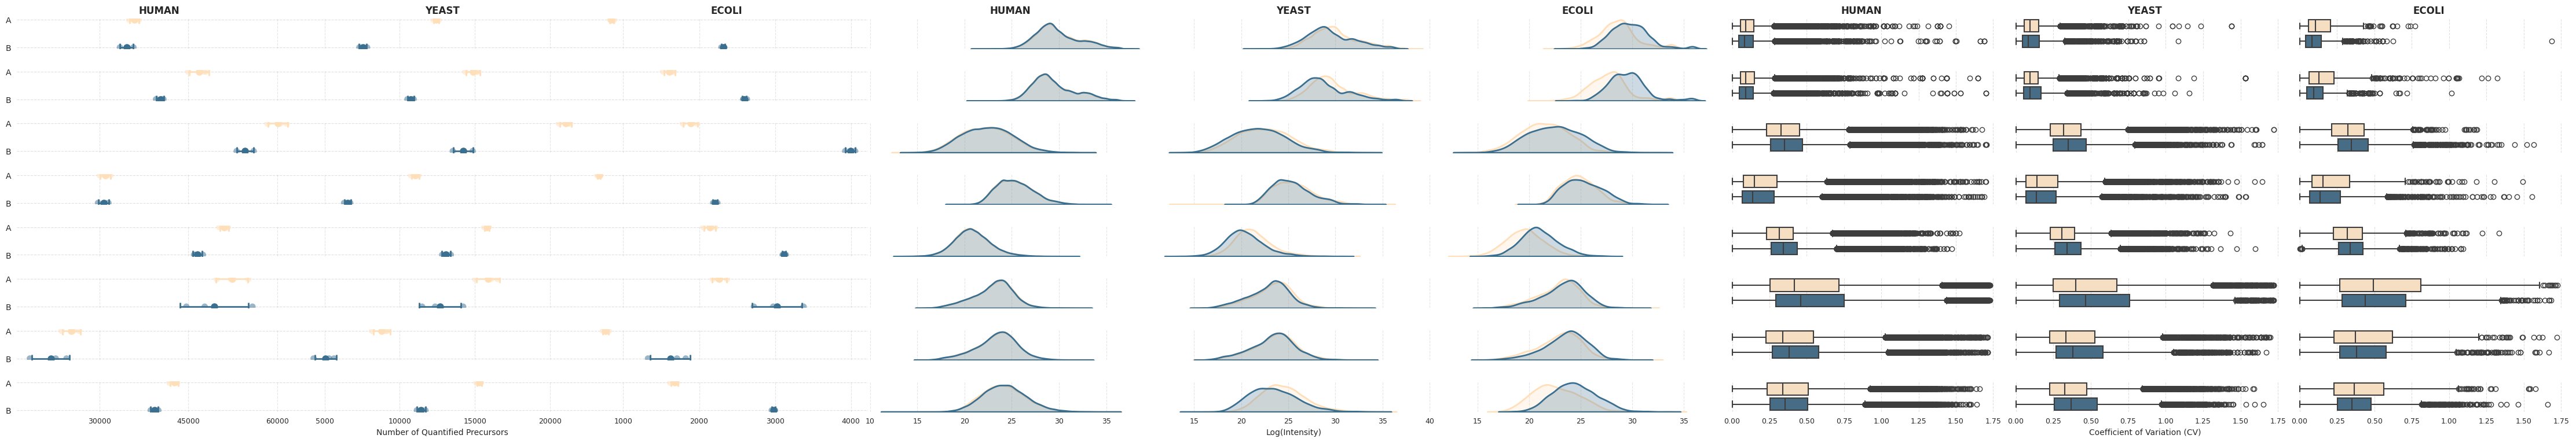

In [340]:
performance_df_dict = prepare_performance_dict(results, mapper=None)
combined_species_plots(performance_df_dict)

## Intersection between all the search engines: How do the unique quantifications perform?

In [341]:
%matplotlib inline

In [342]:
# TODO: find out how UpsetPlot orders its data so as not to hardcode this
all_tools_mapper = {
    "[False, False, False, False, True, False, False]": "DIA-NN",
    "[False, False, False, False, False, True, False]": "MaxQuant (filtered)",
    "[False, False, False, True, False, False, False]": "FragPipe (DIA-NN quant)",
    "[True, False, False, False, False, False, False]": "AlphaDIA",
    "[False, True, False, False, False, False, False]": "AlphaDIA two-step",
    "[False, False, True, False, False, False, False]": "FragPipe",
    "[False, False, False, False, False, False, True]": "MSAID",
    "[True, True, True, True, True, True, False]": "all but MSAID",
    "[True, True, False, True, True, True, True]": "all but FragPipe",
    "[True, False, True, True, True, True, True]": "all but AlphaDIA two-step",
    "[False, True, True, True, True, True, True]": "all but AlphaDIA",
    "[True, True, True, False, True, True, True]": "all but FragPipe (DIA-NN quant)",
    "[True, True, True, True, True, False, True]": "all but MaxQuant (filtered)",
    "[True, True, True, True, False, True, True]": "all but DIA-NN",
    "[True, True, True, True, True, True, True]": "all",
}

In [343]:
performance_df_dict.pop("MaxQuant")

,precursor ion,log_Intensity_mean_A,log_Intensity_mean_B,log_Intensity_std_A,log_Intensity_std_B,Intensity_mean_A,Intensity_mean_B,Intensity_std_A,Intensity_std_B,CV_A,...,LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02,LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03,nr_observed,YEAST,ECOLI,HUMAN,unique,species,log2_expectedRatio,epsilon
0,AAAAAAAAAAAPPAPPEGASPGDSARQK|Z=3,NaN,18.373783,NaN,0.386817,NaN,345795.0,NaN,9.161983e+04,NaN,...,410580.0,NaN,2,False,False,True,1,HUMAN,0.0,NaN
1,AAAAAAAAAAGAAGGRGSGPGR|Z=3,19.894273,NaN,NaN,NaN,974480.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1,False,False,True,1,HUMAN,0.0,NaN
2,AAAAAAAAAVSR|Z=2,24.733432,24.101719,0.626262,0.185155,29218000.0,18077000.0,1.229942e+07,2.313653e+06,0.420953,...,19713000.0,NaN,4,False,False,True,1,HUMAN,0.0,0.631712
3,AAAAAAAAKAK|Z=2,22.101686,NaN,NaN,NaN,4500600.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1,True,False,False,1,YEAST,1.0,NaN
4,AAAAAAAAQMHAK|Z=2,19.929894,22.073471,NaN,0.438212,998840.0,4515625.0,NaN,1.350892e+06,NaN,...,5470850.0,3560400.0,3,False,False,True,1,HUMAN,0.0,-2.143577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129748,YYYAVVDCDSPETASK|Z=3,17.445726,NaN,NaN,NaN,178520.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1,False,False,True,1,HUMAN,0.0,NaN
129749,YYYIPQYKNWR|Z=2,21.641344,22.122310,NaN,NaN,3271100.0,4565400.0,NaN,NaN,NaN,...,4565400.0,NaN,2,False,False,True,1,HUMAN,0.0,-0.480965
129750,YYYIPQYK|Z=2,23.409891,24.719637,1.874939,1.065972,16191550.0,31485550.0,1.661057e+07,2.135526e+07,1.025879,...,46586000.0,16385100.0,4,False,False,True,1,HUMAN,0.0,-1.309746
129751,YYYNCRTEVSQWEK|Z=2,18.878108,19.216072,0.024243,2.431783,481845.0,1095260.0,8.096373e+03,1.287415e+06,0.016803,...,184920.0,2005600.0,4,False,False,True,1,HUMAN,0.0,-0.337964


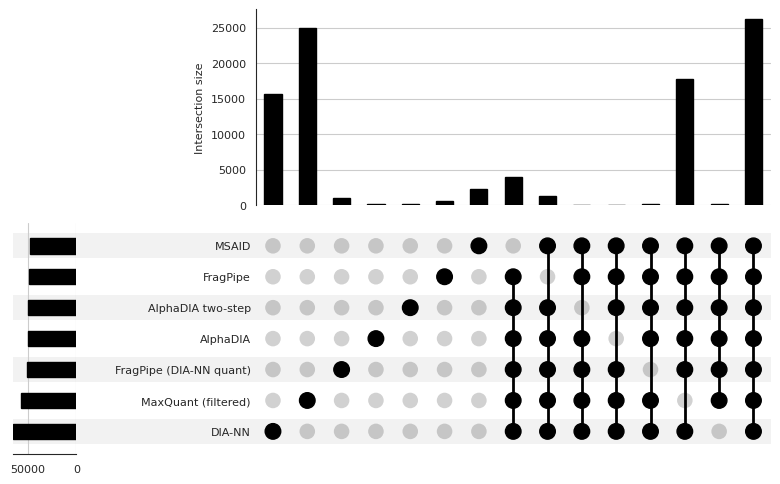

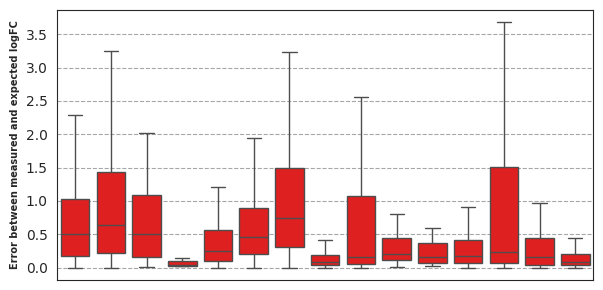

In [344]:
fig = plot_upset_and_boxplot(performance_df_dict, all_tools_mapper)

# Intersection between DIA-NN and AlphaDIA (two-step): Are the unique quants from DIA-NN accurately quantified?

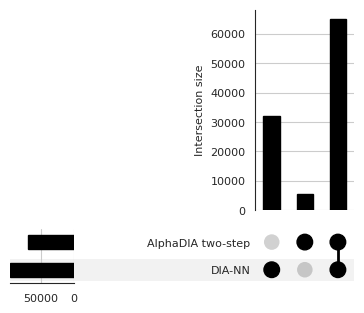

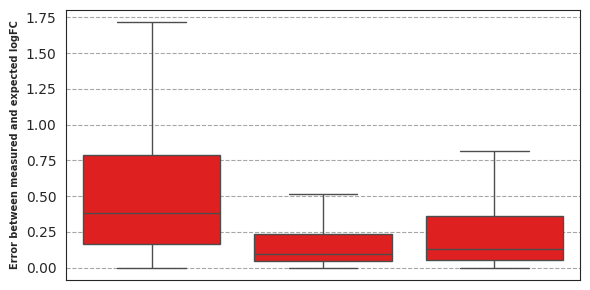

In [345]:
diann_alphadia_performance_dict = {
    "AlphaDIA two-step": performance_df_dict["AlphaDIA two-step"],
    "DIA-NN": performance_df_dict["DIA-NN"],
}
diann_alphadia_mapper = {"[False, True]": "AlphaDIA two-step", "[True, False]": "DIA-NN", "[True, True]": "all"}
fig_diann_alphadia = plot_upset_and_boxplot(diann_alphadia_performance_dict, diann_alphadia_mapper)

In [346]:
# Find the overlap between the quantified precursors
diann_alphadia_merged = pd.merge(
    performance_df_dict["DIA-NN"],
    performance_df_dict["AlphaDIA two-step"],
    on="precursor ion",
    how="inner",
    suffixes=("_diann", "_alphadia"),
)

Text(0.5, 1.0, 'Quantitative accuracy of DIANN and AlphaDIA two-step for precursors quantified by both tools')

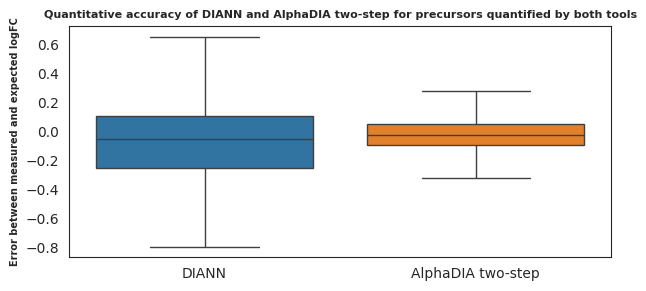

In [347]:
# Plot 2 boxplots of the epsilons of DIANN and AlphaDIA for the overlapping precursors
epsilons = diann_alphadia_merged[["epsilon_diann", "epsilon_alphadia"]]
epsilons.columns = ["DIANN", "AlphaDIA two-step"]
fig, ax = plt.subplots(figsize=(7, 3))

sns.boxplot(data=epsilons, ax=ax, showfliers=False, linewidth=1)
ax.set_ylabel("Error between measured and expected logFC", fontsize=7, fontweight="bold")
ax.set_title(
    "Quantitative accuracy of DIANN and AlphaDIA two-step for precursors quantified by both tools",
    fontsize=8,
    fontweight="bold",
)

# DIA-NN: Differences between versions

In [348]:
file_paths_versioning = {
    "DIA-NN": {
        "1.7.16": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.7.16_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.7.16_default/report.log.txt",
        ),
        "1.8": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.8_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.8_default/report.log.txt",
        ),
        "1.9.1": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.1_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.1_default/report.log.txt",
        ),
        "1.9.2": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.log.txt",
        ),
    }
}

In [349]:
plot, results_versioning = plot_performance_metrics(file_paths_versioning, min_quant=1)
plot

Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.


In [350]:
plot, results_versioning = plot_performance_metrics(file_paths_versioning, min_quant=3)
plot

Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.


In [351]:
plot, results_versioning = plot_performance_metrics(file_paths_versioning, min_quant=6)

Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.


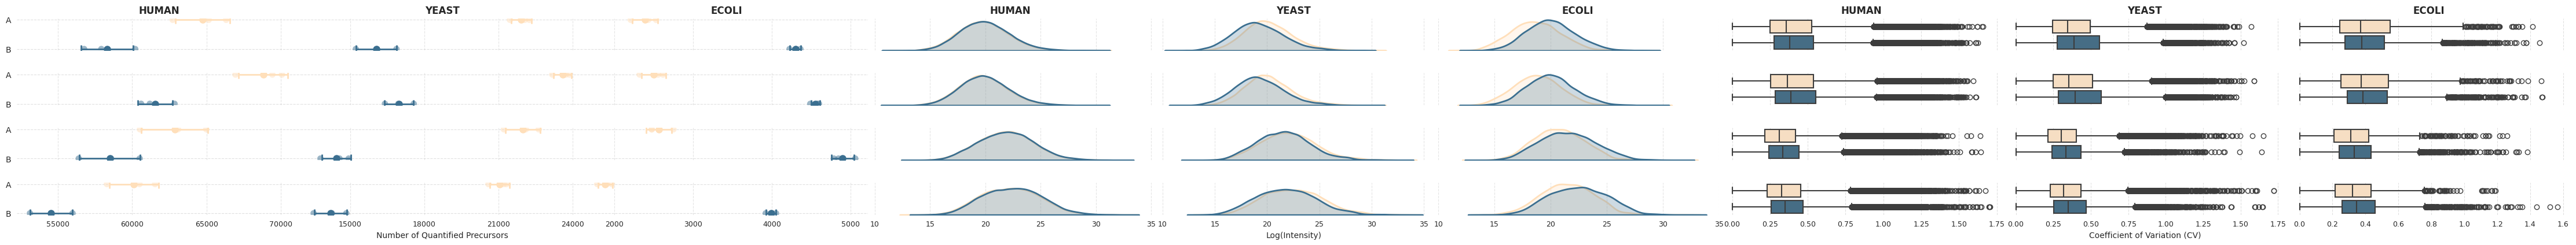

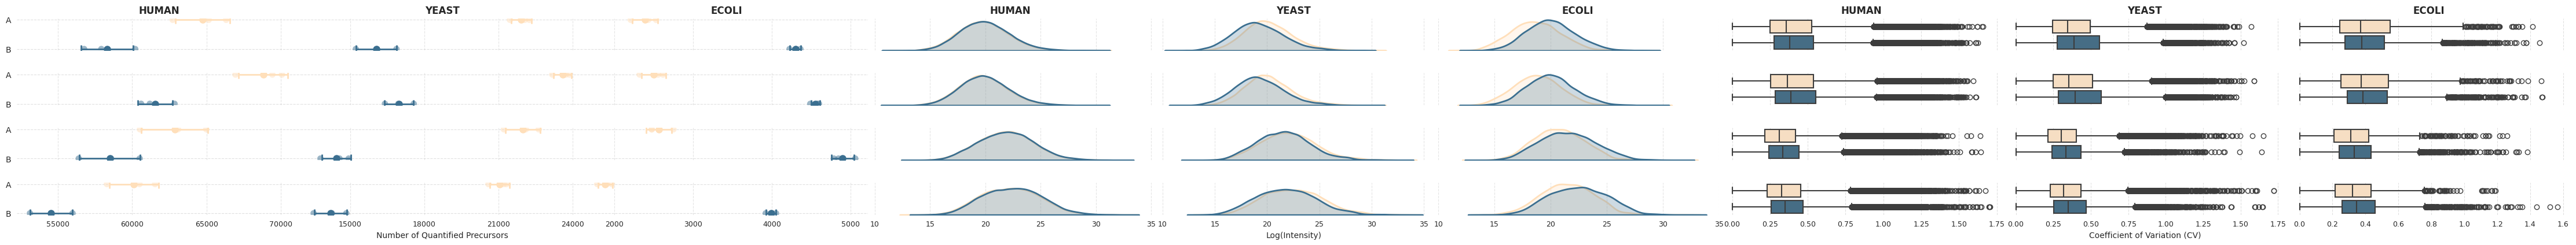

In [352]:
performance_df_dict_versioning = prepare_performance_dict(results_versioning)
combined_species_plots(performance_df_dict_versioning)

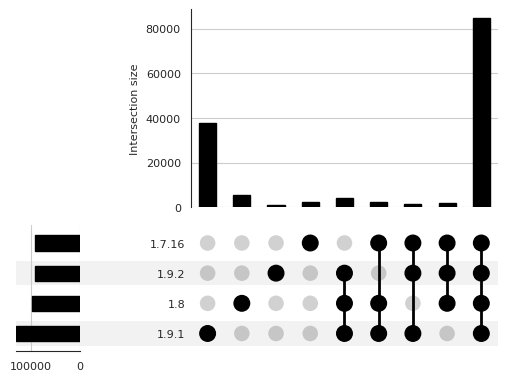

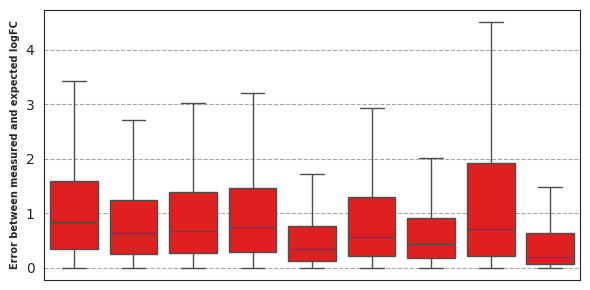

In [353]:
version_mapper = {
    "[False, False, True, False]": "DIA-NN 1.9.1",
    "[False, True, False, False]": "DIA-NN 1.8",
    "[False, False, False, True]": "DIA-NN 1.9.2",
    "[True, False, False, False]": "DIA-NN 1.7.16",
    "[False, True, True, True]": "all but DIA-NN 1.7.16",
    "[True, True, True, False]": "all but DIA-NN 1.9.2",
    "[True, False, True, True]": "all but DIA-NN 1.8",
    "[True, True, False, True]": "all but DIA-NN 1.9.1",
    "[True, True, True, True]": "all",
}

fig = plot_upset_and_boxplot(performance_df_dict_versioning, version_mapper)

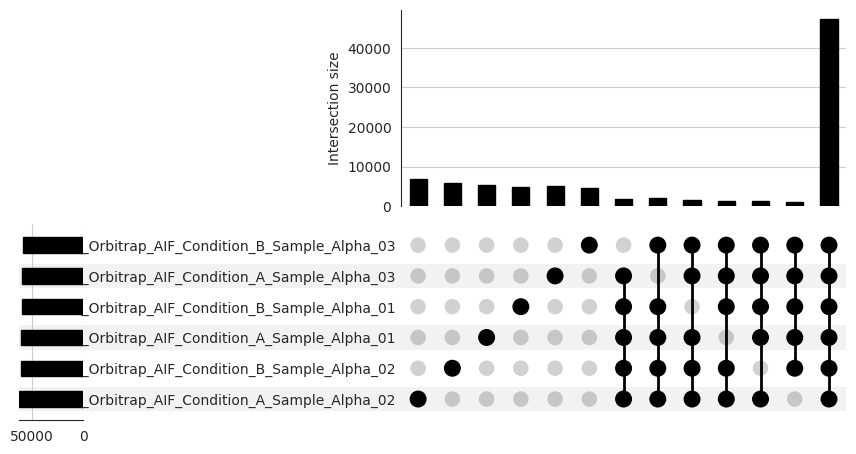

In [354]:
plot_quant_prec_overlap_files(performance_df_dict_versioning["1.9.1"])

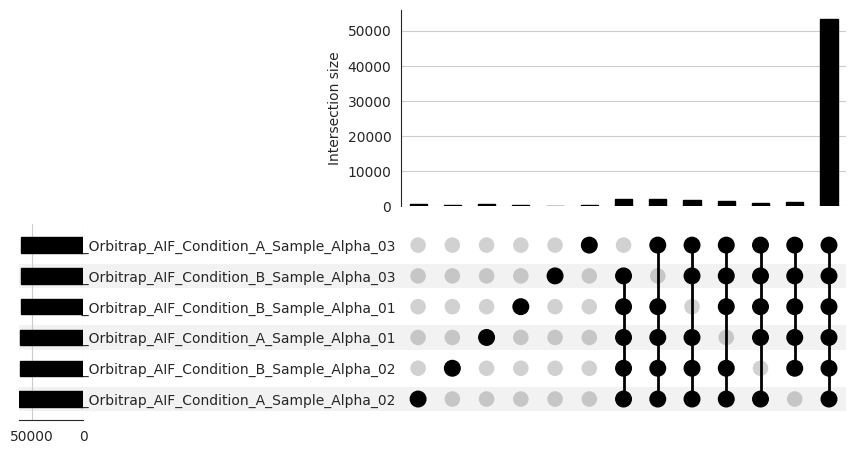

In [355]:
plot_quant_prec_overlap_files(performance_df_dict_versioning["1.9.2"])

# Spectronaut: differences between versions

In [356]:
file_paths_spectronaut_versioning = {
    "Spectronaut": {
        "19.0": (
            "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_0/Experiment1_Report_BGS Factory Report (Normal).tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_0/Experiment1_ExperimentSetupOverview_BGS Factory Settings.txt",
        ),
        "19.1": (
            "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_1/Experiment1_Report_BGS Factory Report (Normal).tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_1/Experiment1_ExperimentSetupOverview_BGS Factory Settings.txt",
        ),
        "19.2": (
            "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_2/Experiment1_Report_BGS Factory Report (Normal).tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_2/Experiment1_ExperimentSetupOverview_BGS Factory Settings.txt",
        ),
        "19.4": (
            "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_4/Experiment1_Report_BGS Factory Report (Normal).tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_4/Experiment1_ExperimentSetupOverview_BGS Factory Settings.txt",
        ),
    }
}

In [357]:
plot, results_spectronaut = plot_performance_metrics(file_paths_spectronaut_versioning)
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


# DIA-NN 1.9.2: FDR control methods

In [358]:
file_paths_fdr = {
    "DIA-NN": {
        "Single NN": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_singlepassnn_secondtry/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_singlepassnn_secondtry/report.logsinglepass.txt",
        ),
        "Double NN": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_doublepassnn_second_try/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_doublepassnn_second_try/report_doublepass.log.txt",
        ),
        "Conservative NN": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_conservativenn/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_conservativenn/report.log.txt",
        ),
        "Linear NN": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_linearclassifier/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_linearclassifier/report.log.txt",
        ),
    }
}

In [359]:
plot, results_fdr = plot_performance_metrics(file_paths_fdr)
plot

Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.


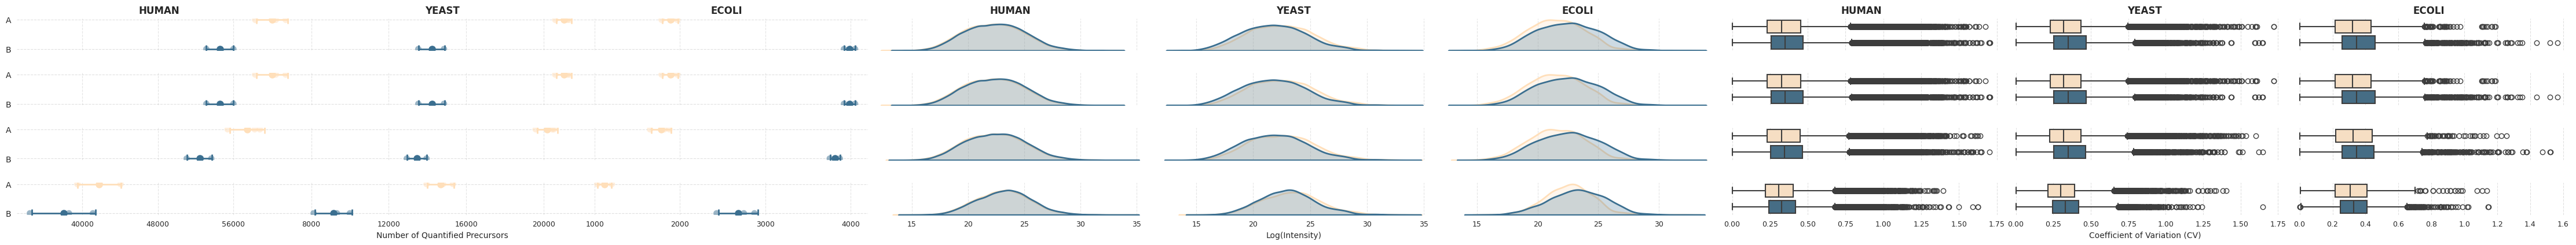

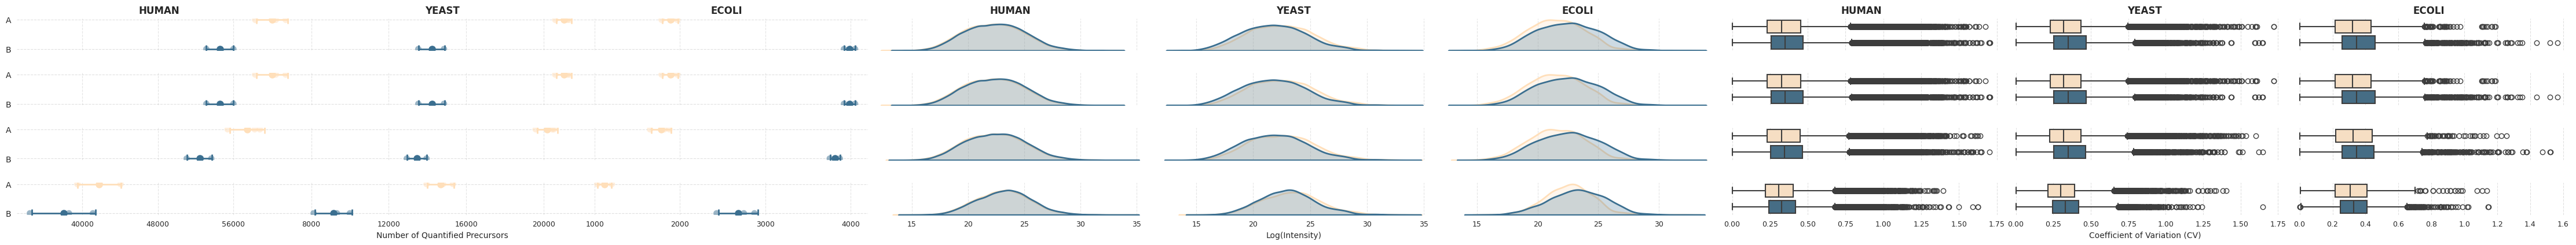

In [360]:
performance_df_dict_fdr = prepare_performance_dict(results_fdr)
combined_species_plots(performance_df_dict_fdr)

In [361]:
performance_df_dict_fdr.pop("Double NN")

,precursor ion,log_Intensity_mean_A,log_Intensity_mean_B,log_Intensity_std_A,log_Intensity_std_B,Intensity_mean_A,Intensity_mean_B,Intensity_std_A,Intensity_std_B,CV_A,...,LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02,LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03,nr_observed,YEAST,ECOLI,HUMAN,unique,species,log2_expectedRatio,epsilon
0,AAAAAAALQAK|Z=1,20.952739,21.036922,0.477874,0.244751,2.099827e+06,2.172067e+06,6.213179e+05,3.634753e+05,0.295890,...,2531050.0,2180890.0,6,False,False,True,1,HUMAN,0.0,-0.084183
1,AAAAAAALQAK|Z=2,27.030010,27.140637,0.720669,0.802504,1.475627e+08,1.621295e+08,6.117862e+07,7.462612e+07,0.414594,...,221843000.0,78469600.0,6,False,False,True,1,HUMAN,0.0,-0.110627
2,AAAAAATAPPSPGPAQPGPR|Z=2,18.982668,18.952280,0.208855,0.062666,5.216210e+05,5.075477e+05,7.433748e+04,2.193243e+04,0.142512,...,484232.0,510643.0,6,False,False,True,1,HUMAN,0.0,0.030389
3,AAAAADLANR|Z=2,21.549036,21.514555,1.061618,0.871649,3.570910e+06,3.336117e+06,1.992393e+06,1.663103e+06,0.557951,...,3723440.0,1513530.0,6,False,False,True,1,HUMAN,0.0,0.034480
4,AAAAALSQQQSLQER|Z=2,18.363518,18.461842,0.141676,0.167711,3.383293e+05,3.626570e+05,3.228531e+04,4.122947e+04,0.095426,...,371594.0,398685.0,6,False,False,True,1,HUMAN,0.0,-0.098325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97967,[Acetyl]-VEEVQK|Z=1,22.156982,21.911880,0.069881,0.108550,4.680130e+06,3.953163e+06,2.288766e+05,2.931538e+05,0.048904,...,3631230.0,4204730.0,6,True,False,False,1,YEAST,1.0,-0.754898
97968,[Acetyl]-VHFTAEEK|Z=2,22.012581,22.309747,0.645634,0.390964,4.495743e+06,5.323640e+06,1.731725e+06,1.376190e+06,0.385192,...,5476000.0,3877610.0,6,False,False,True,1,HUMAN,0.0,-0.297166
97969,[Acetyl]-VLVQDLLHPTAASEAR|Z=2,22.347264,21.183276,0.662848,0.177394,5.704040e+06,2.393093e+06,2.420583e+06,2.880447e+05,0.424363,...,2651030.0,2445980.0,6,True,False,False,1,YEAST,1.0,0.163987
97970,[Acetyl]-VNFTVDQIR|Z=2,19.751101,19.586919,0.418421,1.616503,9.060670e+05,1.047872e+06,2.399651e+05,9.776296e+05,0.264843,...,1739160.0,356583.0,5,False,False,True,1,HUMAN,0.0,0.164182


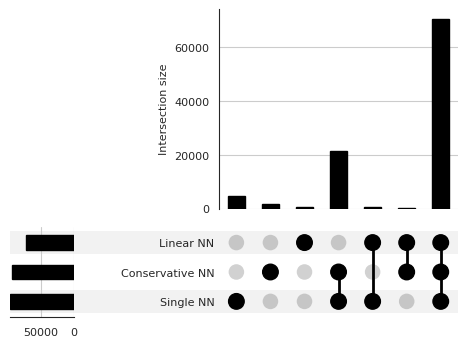

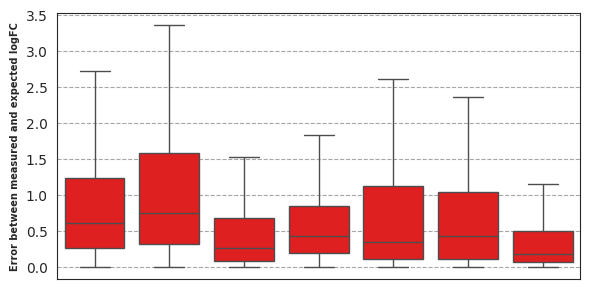

In [362]:
fdr_mapper = {
    "[True, False, False]": "DIA-NN single neural network",
    "[False, True, False]": "DIA-NN conservative neural network",
    "[False, False, True]": "DIA-NN linear classifier",
    "[True, True, False]": "all but DIA-NN linear classifier",
    "[True, False, True]": "all but DIA-NN conservative neural network",
    "[False, True, True]": "all but DIA-NN single neural network",
    "[True, True, True]": "all",
}

fig = plot_upset_and_boxplot(performance_df_dict_fdr, fdr_mapper)

# DIA-NN 1.9.2.: Different quantification strategies

In [363]:
file_paths_quant = {
    "DIA-NN": {
        "High Precision": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.log.txt",
        ),
        "High Accuracy": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_highacc/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_highacc/report.log.txt",
        ),
        "Legacy Quant": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_legacy_quant/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_legacy_quant/report.log.txt",
        ),
    }
}

In [364]:
plot, results_quant = plot_performance_metrics(file_paths_quant)
plot

Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.


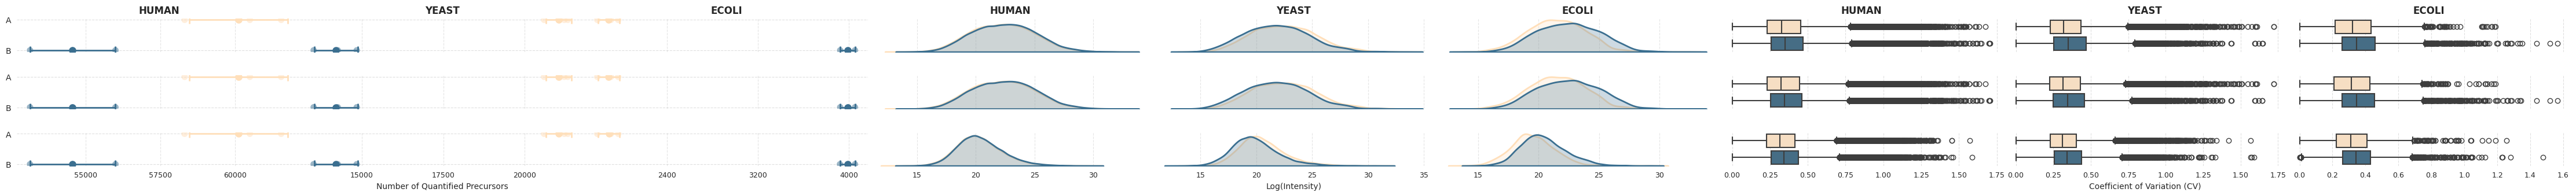

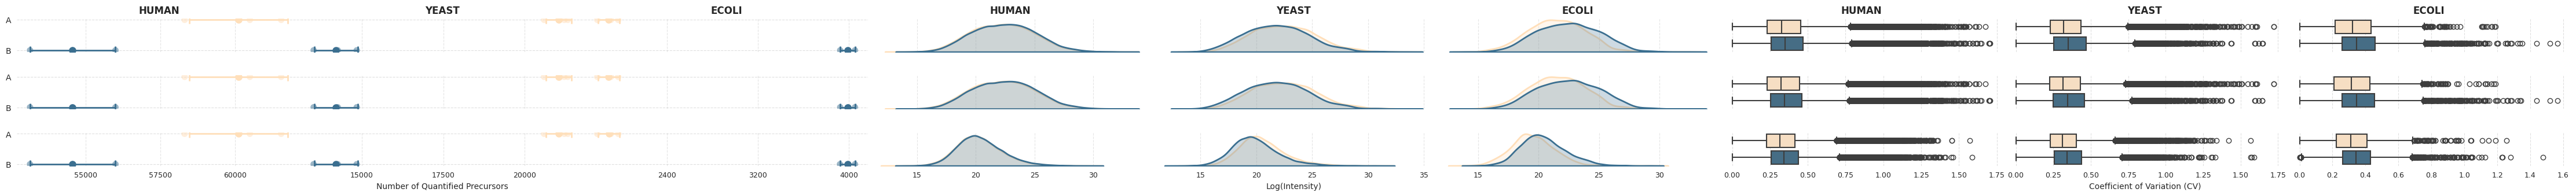

In [365]:
performance_df_dict_quant = prepare_performance_dict(results_quant)
combined_species_plots(performance_df_dict_quant)

In [366]:
# TODO: find a reason for the quant differences, e.g. plot Intensity vs epsilon

# DIA-NN: different library options

In [367]:
file_path_library = {
    "DIA-NN": {
        "In-Built": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.log.txt",
        ),
        "Carafe": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_carafe_lib/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_carafe_lib/report.log.txt",
        ),
        "GPF": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_GP_lib/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_GP_lib/report.log.txt",
        ),
    }
}

In [368]:
plot, results_library = plot_performance_metrics(file_path_library)
plot

Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.
Here
Not all columns required for making the ion are available.


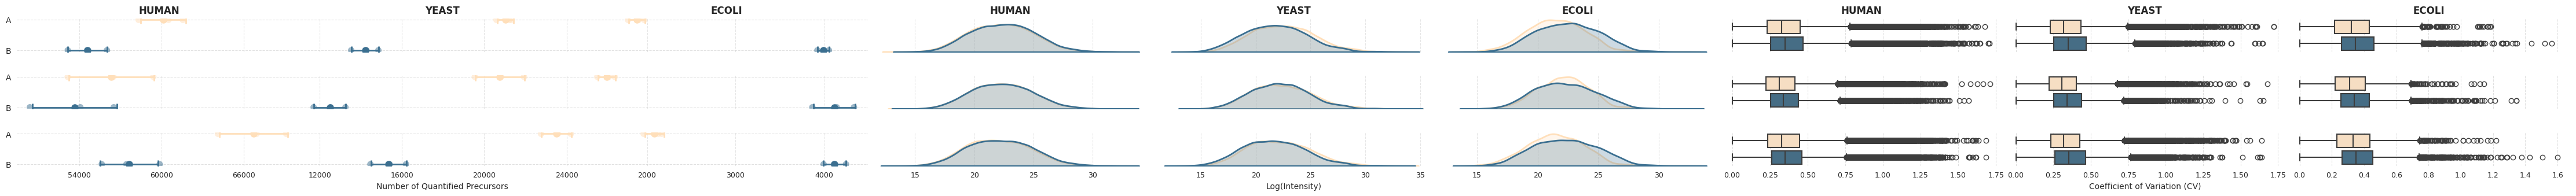

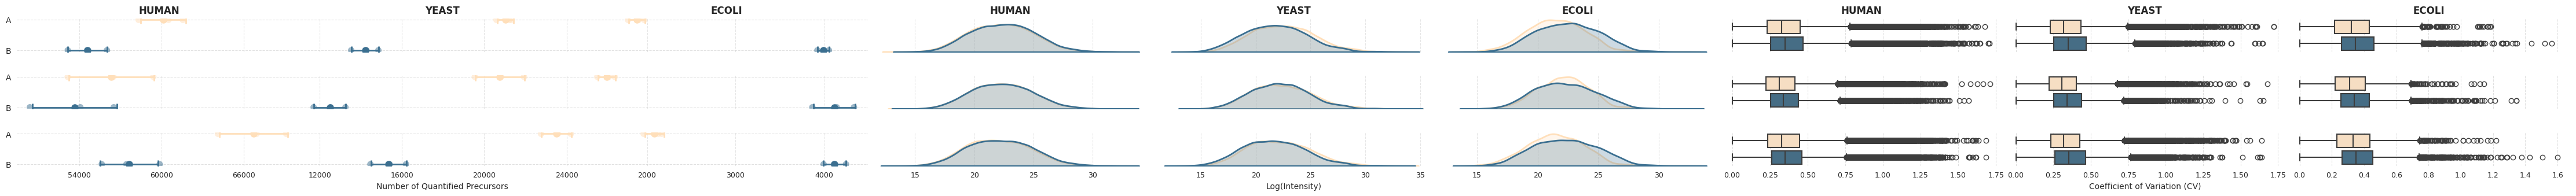

In [369]:
performance_df_dict_library = prepare_performance_dict(results_library)
combined_species_plots(performance_df_dict_library)

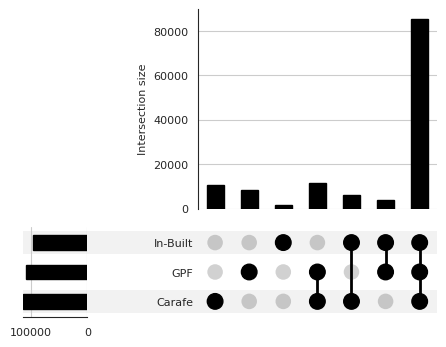

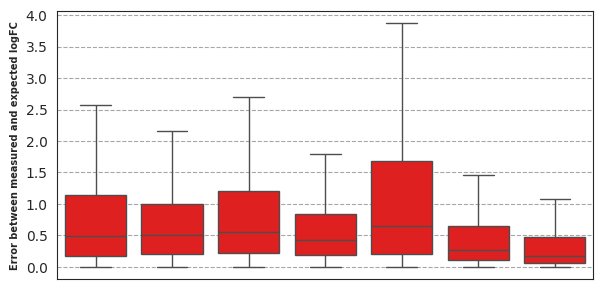

In [370]:
%matplotlib inline
library_mapper = {
    "[False, True, False]": "Carafe library",
    "[False, False, True]": "GP library",
    "[True, False, False]": "DIA-NN inbuilt library",
    "[False, True, True]": "all but DIA-NN inbuilt library",
    "[True, True, False]": "all but GP library",
    "[True, False, True]": "all but Carafe library",
    "[True, True, True]": "all",
}

fig = plot_upset_and_boxplot(performance_df_dict_library, library_mapper)


# Different MSAID quant options

In [371]:
file_paths_msaid = {
    "MSAID": {
        "MS1 apex": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS1_apex/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS1_apex/Proteobench_MS1_apex_details.csv",
        ),
        "MS2 apex": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS2_apex/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS2_apex/Proteobench_MS2_apex_details.csv",
        ),
        "MS2 area": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS2_area/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS2_area/Proteobench_MS2_area_details.csv",
        ),
        "MS1 area": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS1_area/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS1_area/Proteobench_MS1_area_details.csv",
        ),
        "MS2 apex (in all files)": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS2_apex_in_all_files/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS2_apex_in_all_files/Proteobench_MS2_apex_quan_in_all_files_details.csv",
        ),
        "MS2 area (in all files)": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_default/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_default/Proteobench_default_actual_details.csv",
        ),
    }
}

In [372]:
plot, results_msaid = plot_performance_metrics(file_paths_msaid)
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


MSAID
MSAID
MSAID
MSAID
MSAID
MSAID


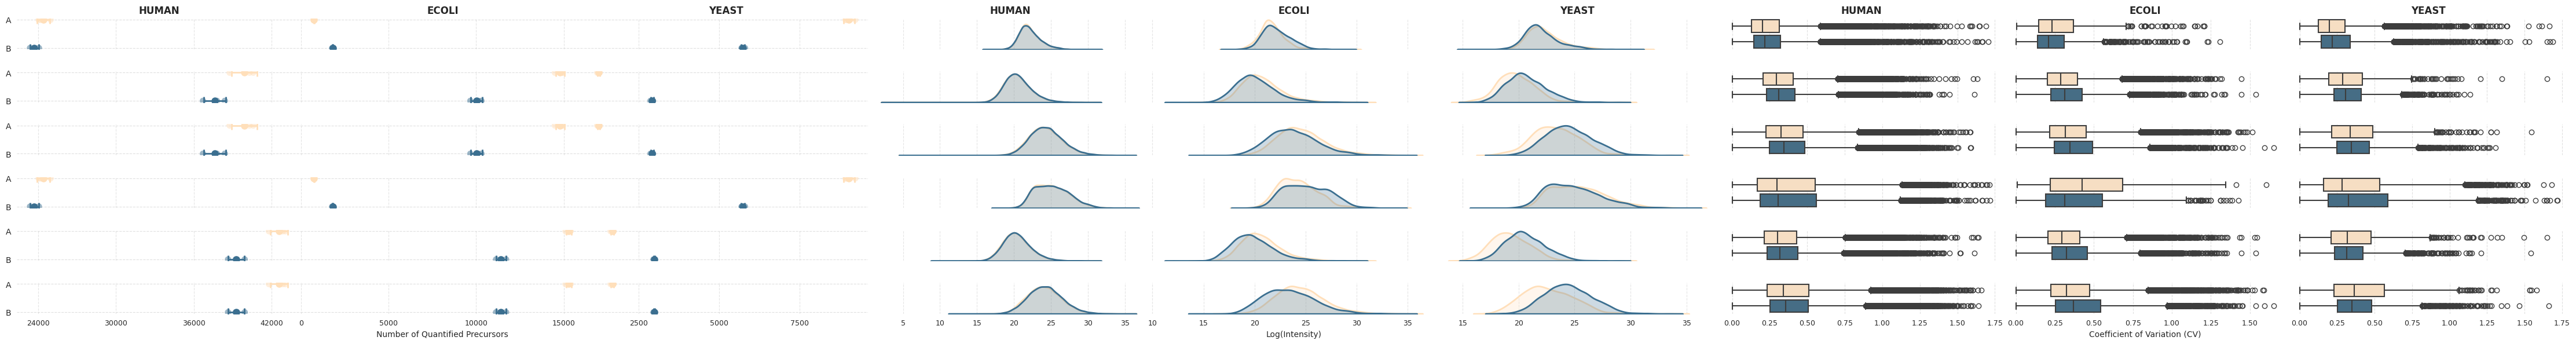

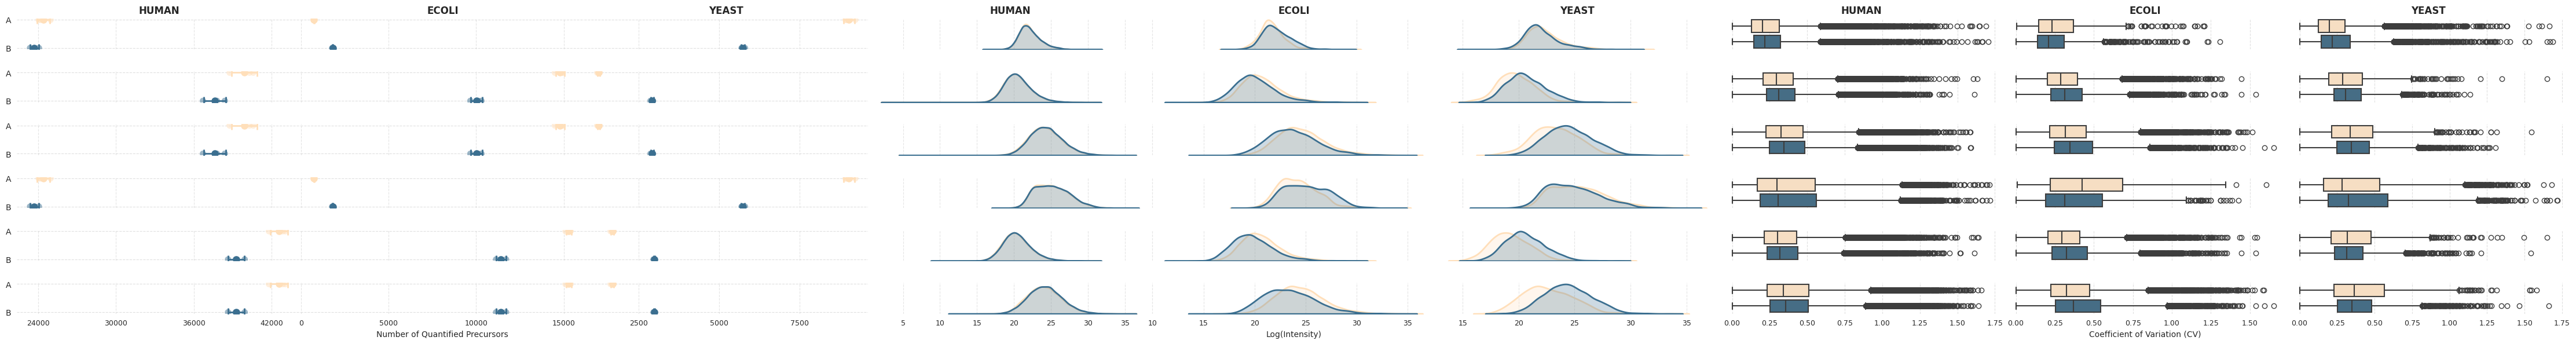

In [373]:
performance_df_dict_msaid = prepare_performance_dict(results_msaid, mapper="MSAID")
combined_species_plots(performance_df_dict_msaid)